In [35]:
#!pip install pandas
#!pip install matplotlib
#!pip install missingno
#!/usr/bin/env python
"""
collection of functions for the final case study solution
"""

import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

#DATA_DIR = os.path.join("..", "cs-train")
DATA_DIR = os.path.join("cs-train")

In [22]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)


In [33]:
def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)


In [31]:
# Load all json formatted files into a dataframe
import re
DATA_DIR = os.path.join("cs-train")
df = fetch_data(DATA_DIR)

In [32]:
# Print original data frame
df

country  customer_id  day invoice  month  price stream_id  \
0       United Kingdom      13085.0   28  489434     11   6.95     85048   
1       United Kingdom      13085.0   28  489434     11   6.75    79323W   
2       United Kingdom      13085.0   28  489434     11   2.10     22041   
3       United Kingdom      13085.0   28  489434     11   1.25     21232   
4       United Kingdom      13085.0   28  489434     11   1.65     22064   
...                ...          ...  ...     ...    ...    ...       ...   
815006  United Kingdom      16098.0   31  562271      7   3.75     22725   
815007  United Kingdom      16098.0   31  562271      7   3.75     22726   
815008  United Kingdom      16098.0   31  562271      7   3.75     22727   
815009  United Kingdom      14056.0   31  562269      7   2.95     22090   
815010  United Kingdom      15628.0   31  562163      7   1.65     22558   

        times_viewed  year invoice_date  
0                 12  2017   2017-11-28  
1                 12  2017   2017-11-28  
2                 21  2017   2017-11-28  
3                  5  2017   2017-11-28  
4                 17  2017   2017-11-28  
...              ...   ...          ...  
815006             2  2019   2019-07-31  
815007            12  2019   2019-07-31  
815008             6  2019   2019-07-31  
815009             2  2019   2019-07-31  
815010            12  2019   2019-07-31  

[815011 rows x 10 columns]

In [36]:
# Quick check on Revenue by Country
revenue_by_country = df[['country', 'price']].groupby('country').sum().sort_values('price', ascending=False)
revenue_by_country = revenue_by_country.rename(columns={'price': 'revenue'})
revenue_by_country = revenue_by_country.reset_index()
revenue_by_country.head()

country       revenue
0  United Kingdom  3.521514e+06
1            EIRE  1.070692e+05
2         Germany  4.927182e+04
3          France  4.056514e+04
4          Norway  3.849475e+04

In [34]:
#given the original DataFrame df return a numerically indexed time-series DataFrame by aggregating over each day
# df_time aggregated over each day
df_orig = df
df_time = convert_to_ts(df_orig, country=None)
df_time

date  purchases  unique_invoices  unique_streams  total_views  \
0   2017-11-01          0                0               0            0   
1   2017-11-02          0                0               0            0   
2   2017-11-03          0                0               0            0   
3   2017-11-04          0                0               0            0   
4   2017-11-05          0                0               0            0   
..         ...        ...              ...             ...          ...   
602 2019-06-26       1358               67             999         6420   
603 2019-06-27       1620               80             944         9435   
604 2019-06-28       1027               70             607         5539   
605 2019-06-29          0                0               0            0   
606 2019-06-30        602               27             423         2534   

    year_month  revenue  
0      2017-11     0.00  
1      2017-11     0.00  
2      2017-11     0.00  
3      2017-11     0.00  
4      2017-11     0.00  
..         ...      ...  
602    2019-06  4903.17  
603    2019-06  5499.38  
604    2019-06  3570.60  
605    2019-06     0.00  
606    2019-06  1793.98  

[607 rows x 7 columns]

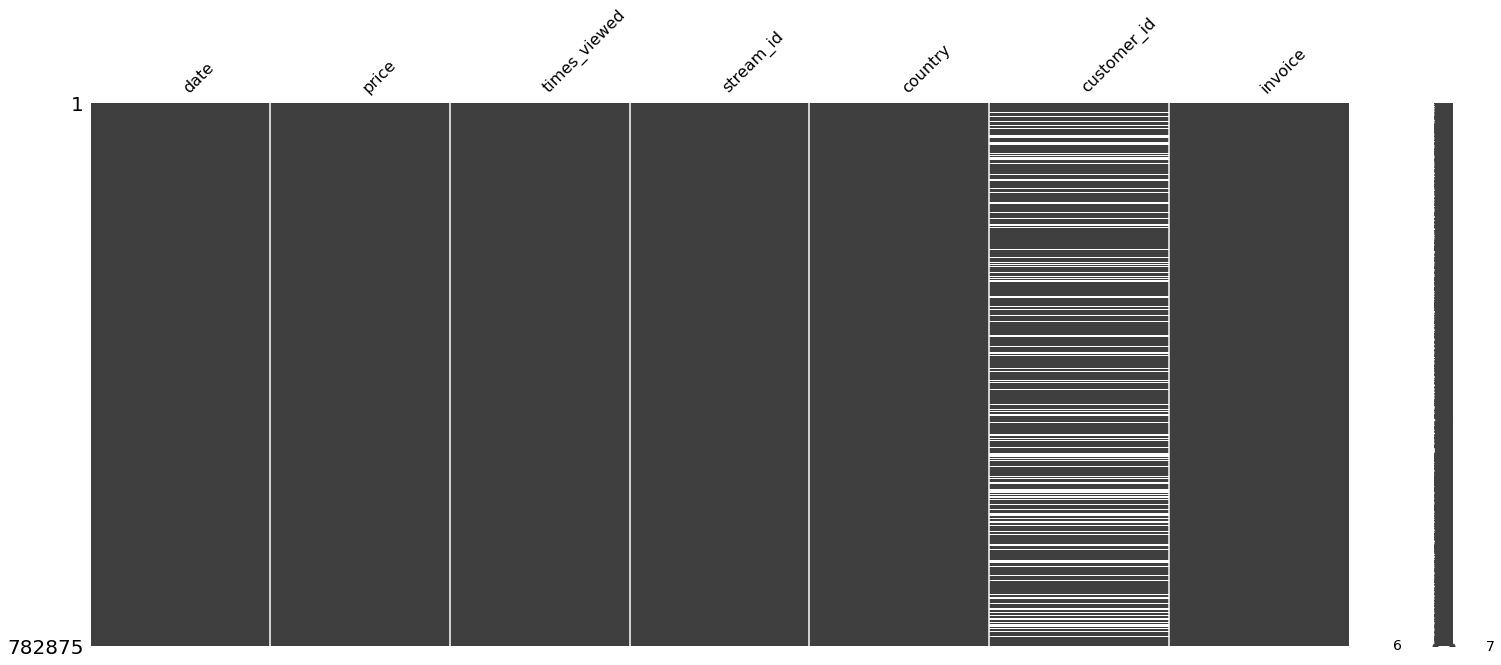

In [12]:
msno.matrix(df)
plt.show()

In [13]:
df['invoice'].value_counts()

537434    1298
538071    1250
537638    1170
537823    1148
536876    1146
          ... 
496968       0
496967       0
496966       0
496965       0
538045       0
Name: invoice, Length: 42646, dtype: int64

C:\Users\PAULOCESARCalabria\Anaconda3\envs\PAULOCESARCalabriaEnv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

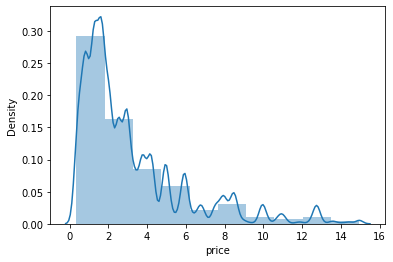

In [14]:
sns.distplot(df['price'], bins=10)

C:\Users\PAULOCESARCalabria\Anaconda3\envs\PAULOCESARCalabriaEnv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


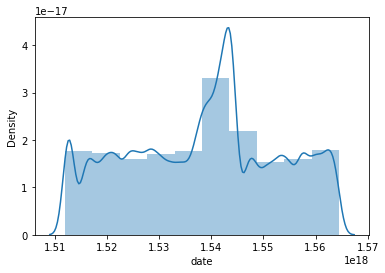

In [15]:
sns.distplot(df['date'], bins=10)
plt.show()

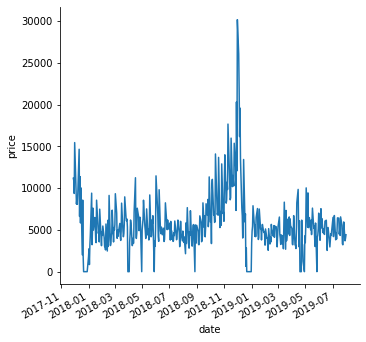

In [16]:
g = sns.relplot(x='date', y='price', data=df.groupby(pd.Grouper(key='date', freq='B')).sum().reset_index(), kind='line')
g.fig.autofmt_xdate()

In [39]:
revenue_by_country = df[['country', 'price']].groupby('country').sum().sort_values('price', ascending=False)
revenue_by_country = revenue_by_country.rename(columns={'price': 'revenue'})
revenue_by_country = revenue_by_country.reset_index()
revenue_by_country.head(10)

country       revenue
0  United Kingdom  3.521514e+06
1            EIRE  1.070692e+05
2         Germany  4.927182e+04
3          France  4.056514e+04
4          Norway  3.849475e+04
5           Spain  1.604099e+04
6       Hong Kong  1.445257e+04
7        Portugal  1.352867e+04
8       Singapore  1.317592e+04
9     Netherlands  1.232280e+04

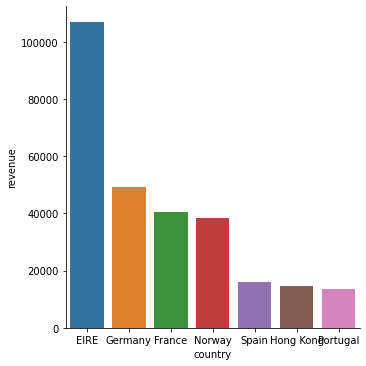

In [46]:
sns.catplot(x='country', y='revenue', data=revenue_by_country[1:8], kind='bar')
plt.show()